## Generating the one of the shortest paths between multiple OGC Features (points)

The current demonstration uses windmills data but can easily be modified to be used with any collection of points served from an OGC Features API

In [14]:
from owslib.ogcapi.features import Features
import matplotlib.pyplot as plt
import networkx as nx

Getting data from an OGC Features API is made easy with the owslib package's Features
It took a total of 3 lines of code to make all required requests for data:
- Features object gets passed a url to an OGC Features API
- then call collection_items on the instance of the object to get the collection
    - this corresponds with OGC Features /collections/{collection_name}/items endpoint

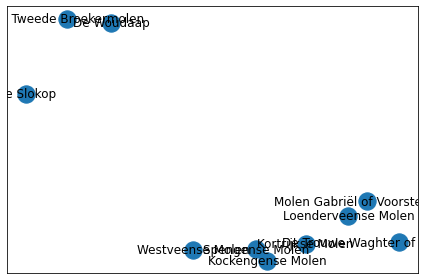

In [15]:
api = Features('https://apitestbed.geonovum.nl/pygeoapi')
collection = api.collection_items('dutch_windmills')

places = {}

for feature in collection["features"]:
    places[feature["properties"]["NAAM"]] = (feature['geometry']['coordinates'][0], feature['geometry']['coordinates'][1])


def showGraph(nodeDict):
    fig = plt.figure()
    axg = fig.add_subplot(111)
    G=nx.Graph()
    for k in nodeDict.keys():
        G.add_node(k, coor=nodeDict.get(k))
        
    pos=nx.get_node_attributes(G,'coor')
    nx.draw(G, pos, with_labels = True)
    plt.axis('on')
    plt.tight_layout()
    plt.show()
    
def showPath(path, nodeDict):
    fig = plt.figure()
    axg = fig.add_subplot(111)

    G=nx.DiGraph()
    for k in path:
        G.add_node(k, pos=nodeDict.get(k))
        
    for i in range(len(path) - 1):
        x = path[i]
        y = path[i + 1]
        G.add_edge(x,y)
        
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G, pos, with_labels = True, edge_color = ['b', 'r', 'c', 'y', 'g', 'm'], arrows=True)   
    plt.axis('on')
    plt.tight_layout()
    fig.canvas.resizable = True
    plt.show()
    
showGraph(places)

The graph above is simply plotted based on their longitude and latitude, no unprojection is needed as the goal of the notebook is to calculate shortest paths rather than accurate visualization.

The below code segment shows has many lines commented out, initially I was implementing the Haversine formula. Later I found a helpful package known as geopy. In implementing geopy I noticed the following:
- geopy has a very limited set of ellipsoids it supports
- it reads coordinates as latitude, longitude rather than longitude, latitude. This inconsistency can lead of some very frusturating bugs

In [16]:
import math
from geopy.distance import geodesic
def toRad(deg):
    return deg * (math.pi / 180)

def dist(c1, c2):
    lon1, lat1 = c1
    lon2, lat2 = c2
    return geodesic((lat1, lon1), (lat2, lon2), ellipsoid='WGS-84').km
#     r = 6356.752314245179
#     dlon, dlat = (toRad(lon2) - toRad(lon1)), (toRad(lat2) - toRad(lat1))
    
#     a = (math.sin(dlat / 2) ** 2) + \
#         (math.cos(toRad(lat1)) * math.cos(toRad(lat2))) + \
#         (math.sin(dlon / 2) ** 2)
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
#    return r * c

def distDict(nodes):
    distance = {}
    for k in nodes.keys():
        for m in nodes.keys():
            distance[k,m] = dist(nodes.get(k), nodes.get(m))
    return distance

In [17]:
def totalDist(path, distDict):
    total = 0
    for i in range(len(path) - 1):
        x = path[i]
        y = path[i+1]
        total += distDict[x, y]
    return round(total,3)

Greedy solution is a basic solution that generated a best path by taking the best option at each part of the path. This solution is not always optimal as making the best choice locally doesn't always lead to the optimal overall path. This solution is later used to initialize a more complicated solution known as simulated anneal.

In [18]:
import random

def closestNode(nodeLabel, otherNodesLabels, distDict):
    minDist = min( (distDict[nodeLabel,k], k) for k in otherNodesLabels)
    foundNode = minDist[1]
    return foundNode

def greedySolution(nodes, distDict):
    cur = random.choice(list(nodes.keys()))
    solution = [cur]
    free = list(nodes.keys())
    free.remove(cur)
    while free:
        found = closestNode(cur, free, distDict)
        cur = found
        free.remove(cur)
        solution.append(cur)
    return solution

Simulated annealling is an algorithm that was inspired of crystal structures as they cool down over time. It uses the same concept to lower the tolerance of randomness introduced in generating the "best" path. As it cools down it stablizes on a likely best path and returns that as a solution.

This animation is a visualization of the process: [animation](https://upload.wikimedia.org/wikipedia/commons/d/d5/Hill_Climbing_with_Simulated_Annealing.gif "animation")

The variables used are:
- T, the tempurtature
- alpha, the rate at which tempurature decreases
- stoppingTemperature, temporarture to stop at
- allDist, this is a dictionary of all distances from one place to another
- curSolution, is the current solution, it's intialized with greedy solution

In [21]:
class SimAnneal(object):
    def __init__(self, nodes, distDict):
        self.nodes = nodes
        self.N = len(nodes)
        self.T = math.sqrt(self.N)
        self.alpha = 0.995
        self.stoppingTemperature = 0.00000001
        self.stoppingIter = 100000
        self.iteration = 1
        self.allDist = distDict
        self.curSolution = greedySolution(nodes, distDict)

        self.bestSolution = list(self.curSolution)
        self.curFitness = self.fitness(self.curSolution)
        self.initialfitness = self.curFitness
        self.bestFitness = self.curFitness
        self.fitnessList = [self.curFitness]


    def fitness(self, sol):
        return totalDist(sol, self.allDist)

    def pAccept(self, candidateFitness):
        return math.exp(-abs(candidateFitness - self.curFitness) / self.T)

    def accept(self, candidate):
        candidateFitness = self.fitness(candidate)
        if candidateFitness < self.curFitness:
            self.curFitness = candidateFitness
            self.curSolution = candidate
            if candidateFitness < self.bestFitness:
                self.bestFitness = candidateFitness
                self.bestSolution = candidate
        else:
            if random.random() < self.pAccept(candidateFitness):
                self.curFitness = candidateFitness
                self.curSolution = candidate

    def anneal(self):
        while (self.T >= self.stoppingTemperature) and (self.iteration < self.stoppingIter):
            candidate = list(self.curSolution)
            l = random.randint(2, self.N - 1)
            i = random.randint(0, self.N - l)
            candidate[i:(i + l)] = reversed(candidate[i:(i + l)])
            self.accept(candidate)
            self.T *= self.alpha
            self.iteration += 1
            self.fitnessList.append(self.curFitness)
        return self.bestSolution
    def plotLearning(self):
        plt.plot([i for i in range(len(self.fitnessList))], self.fitnessList)
        plt.ylabel('Fitness/Distance (km)')
        plt.xlabel('Iteration')
        plt.show()

--------------------------------------------
Best Path So Far: ['De Woudaap', 'De Tweede Broekermolen', 'De Slokop', 'Westveense Molen', 'Spengense Molen', 'Kockengense Molen', 'Kortrijkse Molen', 'De Trouwe Waghter of Trouwe Wachter', 'Loenderveense Molen', 'Molen Gabriël of Voorste Molen']
Total Distance of: 74.332 km


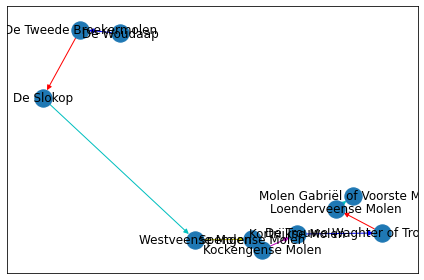

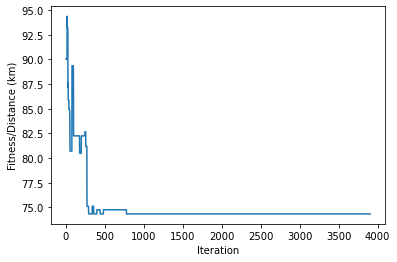

In [22]:
placesDist = distDict(places)
sa = SimAnneal(places, placesDist)
sol = sa.anneal()
print("--------------------------------------------")
print("Best Path So Far: " + str(sol))
print("Total Distance of: " + str(sa.fitness(sol)) + " km")
showPath(sol, places)
sa.plotLearning()

Above you can see the actual path visualized on a figure, it also gives you the total distance. Below that is a figure of the best solutions distance over iterations.

Overall using OGC Features API with python (+ jupyter) is very simple and takes little effort. The process of retreiving data needed for analysis is simple which allows the client to focus on the analysis portion rather than having to navigate an API's endpoints to begin processing data. A comparsion that comes to mind is the difference of using CSV versus some proprietary solution. With CSV you already know the format and structure, making using the data easier, for a proprietary solution are required to spend development time learning about the data structure before you are able to interact with the data itself.